In [2]:
!pip install -e ../CauseML

Obtaining file:///home/jovyan/work/CauseML
     |████████████████████████████████| 307kB 3.5MB/s eta 0:00:01
  Running setup.py develop for cause-ml


In [14]:
from cause_ml.parameters import build_parameters_from_metric_levels
from cause_ml.constants import Constants
from cause_ml.data_generation import DataGeneratingProcessWrapper
import cause_ml.data_sources as data_sources
from cause_ml.utilities import extract_treat_and_control_data, random_covar_matrix

In [15]:
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from functools import partial
from multiprocessing import Pool
from IPython.display import clear_output
import time as timer

In [17]:
import rpy2
from rpy2 import robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import numpy2ri
from rpy2.robjects import IntVector, FloatVector, Matrix, ListVector
numpy2ri.activate()

In [18]:
from IPython.core.debugger import set_trace

## Data Generation Code

In [19]:
PARTIAL_CORRELATION_DEG = 0.1

In [20]:
def generate_original_data(
    prop_score=0.5,
    n_covars=20,
    n_observations=50000):
    
    covariance_matrix = random_covar_matrix(
        dimension=n_covars,
        correlation_deg=PARTIAL_CORRELATION_DEG)

    # Generate random covariates
    covar_data = np.random.multivariate_normal(
        mean=np.full((n_covars,), 0),
        cov=covariance_matrix,
        size=n_observations)
    
    outcome_coeffs = np.random.uniform(-5, 5, size=20)
    
    noise = np.random.normal(size=n_observations)
    Y0 = (covar_data @ outcome_coeffs) + \
        5*((covar_data[:, 0] > 0.5).astype(int)) + \
        noise
    Y1 = Y0 + 8*((covar_data[:, 1] > 0.1).astype(int))
    
    TE = Y1 - Y0
    T = (np.random.uniform(0, 1, size=n_observations) < prop_score).astype(int)
    Y = T*Y1 + (1-T)*Y0
    
    obs_data = pd.DataFrame(data=covar_data)
    obs_data["T"] = T
    obs_data["Y"] = Y
    
    oracle_data = pd.DataFrame({
        "TE": TE,
        "NOISE(Y)": noise,
        "Y0": Y0,
        "Y1": Y1,
        "P(T|X)": prop_score
    })
    
    return obs_data, oracle_data

In [21]:
def generate_original_data_with_normalized_base(
    prop_score=0.5,
    n_covars=20,
    n_observations=50000):
    
    covar_data_source = data_sources.load_random_normal_covariates(
        n_covars=n_covars,
        n_observations=n_observations,
        partial_correlation_degree=PARTIAL_CORRELATION_DEG)
    
    covar_data = covar_data_source.original_covariate_data.to_numpy()
    
    outcome_coeffs = np.random.uniform(-5, 5, size=20)
    
    noise = np.random.normal(size=n_observations)
    Y0 = (covar_data @ outcome_coeffs) + \
        5*((covar_data[:, 0] > 0.5).astype(int)) + \
        noise
    Y1 = Y0 + 8*((covar_data[:, 1] > 0.1).astype(int))
    
    TE = Y1 - Y0
    T = (np.random.uniform(0, 1, size=n_observations) < prop_score).astype(int)
    Y = T*Y1 + (1-T)*Y0
    
    obs_data = covar_data_source.original_covariate_data.copy()
    obs_data["T"] = T
    obs_data["Y"] = Y
    
    oracle_data = pd.DataFrame({
        "TE": TE,
        "NOISE(Y)": noise,
        "Y0": Y0,
        "Y1": Y1,
        "P(T|X)": prop_score
    })
    
    return obs_data, oracle_data

In [22]:
def generate_hybrid_data(
    prop_score=0.5,
    n_covars=20,
    n_observations=50000):
    
    covar_data_source = data_sources.load_random_normal_covariates(
        n_covars=n_covars,
        n_observations=n_observations,
        partial_correlation_degree=PARTIAL_CORRELATION_DEG)

    dgp_params = build_parameters_from_metric_levels({
        Constants.MetricNames.TREATMENT_NONLINEARITY: Constants.MetricLevels.LOW,
        Constants.MetricNames.OUTCOME_NONLINEARITY: Constants.MetricLevels.LOW,
        Constants.MetricNames.TE_HETEROGENEITY: Constants.MetricLevels.LOW
    })
    
    dgp_params.set_parameter("MIN_PROPENSITY_SCORE", 0.001)
    dgp_params.set_parameter("MAX_PROPENSITY_SCORE", 0.9999)
    dgp_params.set_parameter("TREATMENT_EFFECT_HETEROGENEITY", 0.05)
    dgp_params.set_parameter("OUTCOME_NOISE_TAIL_THICKNESS", 300)
    dgp_params.set_parameter("TARGET_PROPENSITY_SCORE", prop_score)
    dgp_params.set_parameter("ACTUAL_CONFOUNDER_ALIGNMENT", 0)
    
    dgp_params.set_parameter("TREAT_MECHANISM_COVARIATE_SELECTION_PROBABILITY",
                             {
                                "LINEAR": 0,
                                "POLY_QUAD": 0.0,
                                "POLY_CUBIC": 0.0,
                                "STEP_JUMP": 0,
                                "STEP_KINK": 0,
                                "INTERACTION_TWO_WAY": 0,
                                "INTERACTION_THREE_WAY": 0
                             })
    dgp_params.set_parameter("OUTCOME_MECHANISM_COVARIATE_SELECTION_PROBABILITY",
                             {
                                "LINEAR": 1,
                                "POLY_QUAD": 0.0,
                                "POLY_CUBIC": 0.0,
                                "STEP_JUMP": 0.05,
                                "STEP_KINK": 0,
                                "INTERACTION_TWO_WAY": 0,
                                "INTERACTION_THREE_WAY": 0
                             })

    dgp_wrapper = DataGeneratingProcessWrapper(
        parameters=dgp_params, data_source=covar_data_source)
    
    
    dgp_wrapper.sample_dgp()
    print(dgp_wrapper.treatment_assignment_function)
    _ = dgp_wrapper.generate_data()
    
    obs_data = dgp_wrapper.get_observed_data()
    oracle_data = dgp_wrapper.get_oracle_data()
    
    return obs_data, oracle_data

In [23]:
observed_data, unobservable_data = generate_hybrid_data(prop_score=0.01)
# observed_data, unobservable_data = generate_original_data(
#     prop_score=0.5, n_observations=int(1e2))
observed_data.head()

-4.59511985013459
-0.345000000000000
0.00999999999999999


AttributeError: 'numpy.float64' object has no attribute 'where'

In [12]:
{1, 2}[0]

TypeError: 'set' object is not subscriptable

In [12]:
unobservable_data.head()

,TE,NOISE(Y),Y0,Y1,P(T|X)
0,8.0,-0.148187,0.386404,8.386404,0.5
1,8.0,0.589123,22.458624,30.458624,0.5
2,0.0,-1.055405,-3.716526,-3.716526,0.5
3,8.0,0.586109,-10.598301,-2.598301,0.5
4,8.0,-0.518693,-10.499547,-2.499547,0.5


## Model Code

In [13]:
def build_mlp():
    return MLPRegressor(
        hidden_layer_sizes=(50, 25, 10),
        activation='relu',
        solver='adam',
        batch_size='auto',
        learning_rate='constant',
        learning_rate_init=0.001,
        power_t=0.5,
        max_iter=1000,
        shuffle=True,
        random_state=1,
        tol=0.0001,
        verbose=False,
        warm_start=False,
        early_stopping=True,
        validation_fraction=0.10,
        epsilon=1e-08,
        n_iter_no_change=5)

def build_reg_forest():
    return RandomForestRegressor(n_estimators=30)

In [14]:
def scikit_T_learner(model_builder, data):
    treated_data, control_data = extract_treat_and_control_data(
        data, data["T"])
    
    # train u1
    u1 = model_builder()
    X_treated = treated_data.drop(["T", "Y"], axis=1)
    u1.fit(X_treated, treated_data["Y"])
    
    # train u0
    u0 = model_builder()
    X_control = control_data.drop(["T", "Y"], axis=1)
    u0.fit(X_control, control_data["Y"])
    
    # Generate potential outcome predictions
    X = data.drop(["T", "Y"], axis=1)
    y_1_predicted = u1.predict(X)
    y_0_predicted = u0.predict(X)
    
    ITE_pred = y_1_predicted - y_0_predicted
    
    return ITE_pred, u1, u0

In [15]:
def scikit_S_learner(model_builder, data):
    # train u1
    u = model_builder()
    X = data.drop("Y", axis=1)
    u.fit(X, data["Y"])
    
    # Generate potential outcomes
    X_under_treatment = X.copy()
    X_under_treatment["T"] = 1
    
    X_under_control = X.copy()
    X_under_control["T"] = 0
    
    y_1_predicted = u.predict(X_under_treatment)
    y_0_predicted = u.predict(X_under_control)
    y_1_predicted - y_0_predicted
    
    ITE_pred = y_1_predicted - y_0_predicted
    
    return  ITE_pred

In [16]:
def scikit_X_learner(model_builder, data, prop_score, u1=None, u0=None):
    treated_data, control_data = extract_treat_and_control_data(
        data, data["T"])
    X_treated = treated_data.drop(["T", "Y"], axis=1)
    X_control = control_data.drop(["T", "Y"], axis=1)

    if u1 is None:
        # train u1
        u1 = model_builder()
        u1.fit(X_treated, treated_data["Y"])
    
    if u0 is None:
        # train u0
        u0 = model_builder()
        u0.fit(X_control, control_data["Y"])
    
    # Find individual treatment effects for treated/controls
    itet = treated_data["Y"] - u0.predict(X_treated)
    itec =  u1.predict(X_control) - control_data["Y"]
    
    # Fit models to the treated and controls
    te1 = model_builder()
    te1.fit(X_treated, itet)
    
    te0 = model_builder()
    te0.fit(X_control, itec)
    
    X = data.drop(["T", "Y"], axis=1)
    te1_predicted = te1.predict(X)
    te0_predicted = te0.predict(X)
    
    # Estimate prop scores
#     lm = LogisticRegression(solver="lbfgs")
#     lm.fit(X, data["T"])
#     prop_scores = lm.predict(X)
    
    # Down-weight observes which are likely to belong
    # to other class.
    te = prop_score*te0_predicted + (1-prop_score)*te1_predicted
    
    return te

## Experiment Code

In [17]:
def score_ITE(ITE_true, ITE_pred):
    return np.mean((ITE_true-ITE_pred)**2)

In [18]:
def evaluate_scikit_learners(model_builder, observed_data, unobservable_data):
    ITE_true = unobservable_data["TE"]
    prop_score_true = unobservable_data["P(T|X)"]
    
    # T learner
    ITE_pred, u1, u0 = scikit_T_learner(model_builder, observed_data)
    T_loss = score_ITE(ITE_true, ITE_pred)
    
    # S learner
    ITE_pred = scikit_S_learner(model_builder, observed_data)
    S_loss = score_ITE(ITE_true, ITE_pred)
    
    # X learner
    ITE_pred = scikit_X_learner(model_builder, observed_data, prop_score_true, u1, u0)
    X_loss = score_ITE(ITE_true, ITE_pred)
    
    return T_loss, S_loss, X_loss

In [19]:
learner_func = partial(evaluate_scikit_learners, build_reg_forest)
%time learner_func(observed_data, unobservable_data)

CPU times: user 250 ms, sys: 0 ns, total: 250 ms
Wall time: 244 ms


(55.42309452177158, 23.13894852625124, 17.962834532925122)

In [20]:
# def evaluate_htree_learners2(observed_data, unobservable_data):
#     '''
#     Python-based HTE, train-test split.
#     '''
#     ITE_true = unobservable_data["TE"].to_numpy()

#     X = observed_data.drop(["Y", "T"], axis=1).to_numpy()
#     y = observed_data["Y"].to_numpy()
#     t = observed_data["T"].to_numpy()
    
#     X_train, X_test, y_train, y_test, t_train, t_test, te_train, te_test = \
#         train_test_split(
#             X, y, t, ITE_true,
#             stratify=t,
#             test_size=0.2, random_state=42)
    
#     d = {'mu.forestry': 'mu_forestry'}
#     ct = importr('causalToolbox', robject_translations=d)
#     threads = 15
    
#     t_train = IntVector(t_train)
#     y_train = FloatVector(y_train)

#     # T learner
#     tl_rf = ct.T_RF(feat=X_train, tr=t_train, yobs=y_train, nthread=threads)
#     T_cate_rf = ct.EstimateCate(tl_rf, X_test)
#     T_loss = score_ITE(te_test, np.array(T_cate_rf))
    
#     # S learner
#     sl_rf = ct.S_BART(feat=X_train, tr=t_train, yobs=y_train,
#                       nthread=threads)
#     S_cate_rf = ct.EstimateCate(sl_rf, X_test)
#     S_loss = score_ITE(te_test, np.array(S_cate_rf))
    
#     # X learner
#     xl_rf = ct.X_BART(feat=X_train, tr=t_train, yobs=y_train,
#                       nthread=threads)
#     X_cate_rf = ct.EstimateCate(xl_rf, X_test)
#     X_loss = score_ITE(te_test, np.array(X_cate_rf))
    
#     return T_loss, S_loss, X_loss

In [21]:
# def evaluate_htree_learners3(observed_data, unobservable_data):
#     '''
#     Python-based HTE, NO train-test split.
#     '''
    
#     ITE_true = unobservable_data["TE"].to_numpy()

#     X = observed_data.drop(["Y", "T"], axis=1).to_numpy()
#     y = FloatVector(observed_data["Y"].to_numpy())
#     t = IntVector(observed_data["T"].to_numpy())

#     ct = importr('causalToolbox')
#     threads = 15

#     # T learner
#     tl_rf = ct.T_RF(feat=X, tr=t, yobs=y, nthread=threads)
#     T_cate_rf = ct.EstimateCate(tl_rf, X)
#     T_loss = score_ITE(ITE_true, np.array(T_cate_rf))
    
#     # S learner
#     sl_rf = ct.S_RF(feat=X, tr=t, yobs=y,
#                       nthread=threads)
#     S_cate_rf = ct.EstimateCate(sl_rf, X)
#     S_loss = score_ITE(ITE_true, np.array(S_cate_rf))
    
#     # X learner
#     xl_rf = ct.X_RF(feat=X, tr=t, yobs=y,
#                       nthread=threads)
#     X_cate_rf = ct.EstimateCate(xl_rf, X)
#     X_loss = score_ITE(ITE_true, np.array(X_cate_rf))
    
#     return T_loss, S_loss, X_loss

In [69]:
from rpy2.robjects.packages import SignatureTranslatedAnonymousPackage

with open("R Code/honest_trees.R", "r") as prog:
    R_prog = ''.join(prog.readlines())
    HonestTrees = SignatureTranslatedAnonymousPackage(R_prog, "HonestTrees")
    
def evaluate_htree_learners(observed_data, unobservable_data):
    '''
    R-based HTE, NO train-test split.
    '''
    tau = unobservable_data["TE"].to_numpy()
    X = observed_data.drop(["Y", "T"], axis=1).to_numpy()
    y = observed_data["Y"].to_numpy()
    t = observed_data["T"].to_numpy()
    
    X_train, X_test, y_train, _, t_train, _, _, tau_test = \
        train_test_split(
            X, y, t, tau,
            stratify=t,
            test_size=0.2, random_state=42)
    
    ITE_true = unobservable_data["TE"].to_numpy()
    y_train = FloatVector(y_train)
    t_train = IntVector(t_train)
    tau_test = FloatVector(tau_test)
    return tuple(HonestTrees.HRF_learners(
        X_train, y_train, t_train, X_test, tau_test, 4))

In [26]:
%time evaluate_htree_learners(observed_data, unobservable_data)

CPU times: user 4.04 s, sys: 308 ms, total: 4.35 s
Wall time: 1.03 s


(3.949935852594812, 17.131452188664213, 5.68588020017316)

In [23]:
def run_trial(trial_index, 
              data_gen_func,
              learner_eval_func,
              prop_score=0.5,
              n_covars=20,
              n_observations=50000):
    
    # Generate random data
    observed_data, unobservable_data = data_gen_func(
        prop_score=prop_score,
        n_covars=n_covars,
        n_observations=n_observations)
    
    # Train and evaluate learners and get loss for T, S, and X.
    learner_losses = learner_eval_func(observed_data, unobservable_data)
    
    return trial_index, learner_losses

In [24]:
def run_experiment(data_gen_func, learner_func, prop_score,
                   N_obs_levels, N_trials,
                   exec_pool, verbose=False):
    results = []
    for n_obs in N_obs_levels:
        if verbose:
            print(f"Running at N={n_obs}. Percent done:", end=" ")
        
        trial_func = partial(run_trial,
            data_gen_func=data_gen_func,
            learner_eval_func=learner_func,
            prop_score=prop_score,
            n_observations=n_obs)

        trial_results = []

        completed_trial_count = 0
        if exec_pool is not None:
            for _, result_row in exec_pool.imap_unordered(trial_func, range(N_trials)):
                trial_results.append(result_row)
                completed_trial_count += 1
                incomplete = N_trials - completed_trial_count
                if verbose:
                    print(int(100*completed_trial_count/N_trials), end=" ")
        else:
            for i in range(N_trials):
                _, result_row = trial_func(i)
                trial_results.append(result_row)
                completed_trial_count += 1
                incomplete = N_trials - completed_trial_count
                if verbose:
                    print(int(100*completed_trial_count/N_trials), end=" ")
    
        trial_results = np.array(trial_results)
        results.append(np.mean(trial_results, axis=0))
        if verbose:
            print("")
        
    return results

In [35]:
N_obs_levels = np.logspace(3, 5.5, 12).astype(int)
N_obs_levels = [1000]

learner_funcs = {
    "regression_forest": partial(evaluate_scikit_learners, build_reg_forest),
    "MLP": partial(evaluate_scikit_learners, build_mlp),
    "Honest Forest": evaluate_htree_learners
}

data_funcs = {
    "original": generate_original_data,
    "original_normed": generate_original_data_with_normalized_base,
    "hybrid": generate_hybrid_data
}

exp_conf = {
    "data_gen_func": data_funcs["original_normed"],
    "learner_func": learner_funcs["Honest Forest"],
    "prop_score": 0.01,
    "N_obs_levels": N_obs_levels,
    "N_trials": 1,
    "N_procs": 1
}

N_obs_levels

[1000]

In [36]:
def execute_config(config, verbose=True):
    N_procs = config.pop("N_procs")
    if N_procs>1:
        with Pool(processes=N_procs) as pool:
            results = run_experiment(**config, exec_pool=pool, verbose=verbose)
    else:
        results = run_experiment(**config, exec_pool=None, verbose=verbose)
    
    res_file = persist_result(config, results)
    return results, res_file

In [37]:
%time results, _ = execute_config(exp_conf)

Running at N=1000. Percent done: 100 
CPU times: user 2.54 s, sys: 320 ms, total: 2.86 s
Wall time: 804 ms


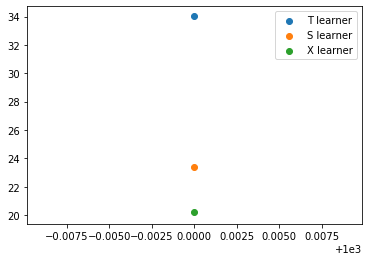

In [38]:
results = np.array(results)
names = ["T learner", "S learner", "X learner"]
N_levels = exp_conf["N_obs_levels"]
for i, name in enumerate(names):
    plt.scatter(N_levels, results[:, i], label=name)
    plt.plot(N_levels, results[:, i])

plt.legend()
plt.show()

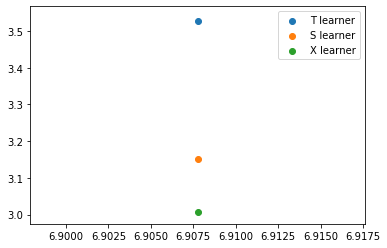

In [39]:
results = np.array(results)
names = ["T learner", "S learner", "X learner"]
for i, name in enumerate(names):
    plt.scatter(np.log(N_obs_levels), np.log(results[:, i]), label=name)

plt.legend()
plt.show()

## Results Caching

In [64]:
import pickle
import uuid
import datetime

RESULT_DIR = "results/kunzel-1/"

def persist_result(config, results):
    unique_filename = str(uuid.uuid4())
    timestamp = str(datetime.datetime.now())

    file_path = RESULT_DIR + unique_filename + " " + timestamp
    result_entry = {
        "configuration": config,
        "result": results
    }

    with open(file_path, "wb") as res_file:
        pickle.dump(result_entry, res_file)
    
    return file_path

In [41]:
file_name = "3d5dd4bc-1498-4757-b9c3-1e9051f4ced1 2019-11-19 23:47:28.466179"
file_path = RESULT_DIR + file_name
with open(file_path, "rb") as res_file:
    result_entry = pickle.load(res_file)
    results = result_entry["res"]
    exp_conf = result_entry["conf"]

## Experiments

In [70]:
N_obs_levels = np.logspace(3.5, 5.5, 12).astype(int)[:-2]

learner_funcs = {
#     "MLP": (partial(evaluate_scikit_learners, build_mlp), 3),
    "Honest Forest": (evaluate_htree_learners, 2)
}

data_funcs = {
#     "original": generate_original_data,
#     "original_normed": generate_original_data_with_normalized_base,
    "hybrid": generate_hybrid_data
}

configs = []
for data_gen_fun_name in data_funcs.keys():
    for learner_func_name in learner_funcs.keys():
        learner_func, cores = learner_funcs[learner_func_name]
        exp_conf = {
            "data_gen_func": data_funcs[data_gen_fun_name],
            "learner_func": learner_func,
            "prop_score": 0.01,
            "N_obs_levels": N_obs_levels,
            "N_trials": 30,
            "N_procs": cores
        }
        configs.append(exp_conf)
        
N_obs_levels

array([  3162,   4806,   7305,  11103,  16876,  25650,  38986,  59255,
        90062, 136887])

In [63]:
result_files = []
for config in configs:
    %time _, result_file = execute_config(config, verbose=False)
    result_files.append(result_file)

CPU times: user 610 ms, sys: 340 ms, total: 950 ms
Wall time: 7min 45s
